In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 12.4 MB/s eta 0:00:00


In [ ]:
import os
import rasterio
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from google.colab import drive
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Concatenate

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
images_path = r'/content/drive/Othercomputers/My Laptop/Software_Engineering/Artificial_Intelligence/Cellula_Internship/Computer_Vision/Datasets/Water_Segmentation/images/'
labels_path = r'/content/drive/Othercomputers/My Laptop/Software_Engineering/Artificial_Intelligence/Cellula_Internship/Computer_Vision/Datasets/Water_Segmentation/labels/'

Number of images: 306
Number of labels: 456


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Width: 128, Height: 128, Bands: 12


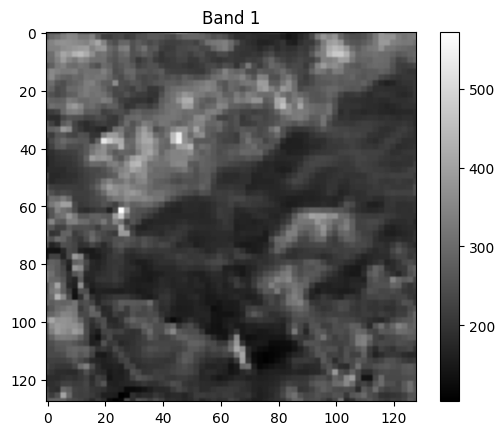

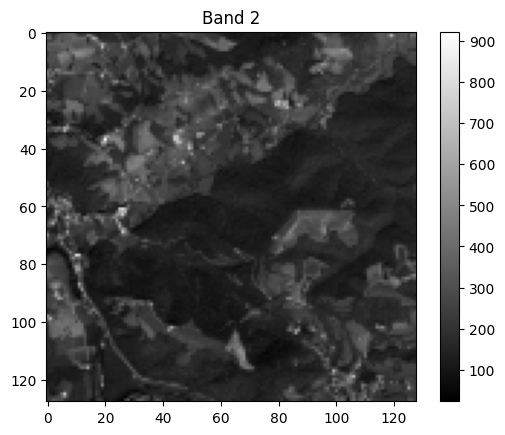

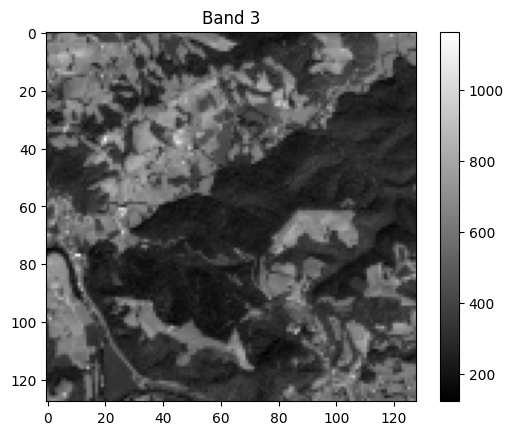

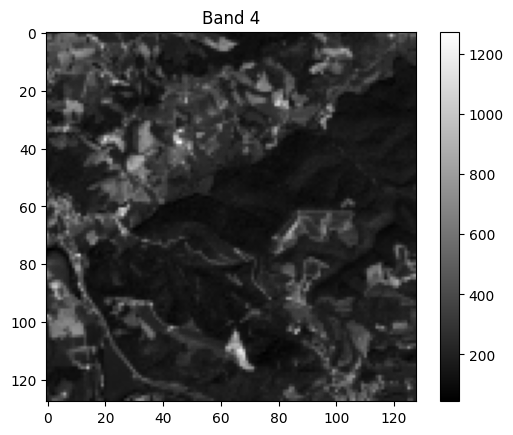

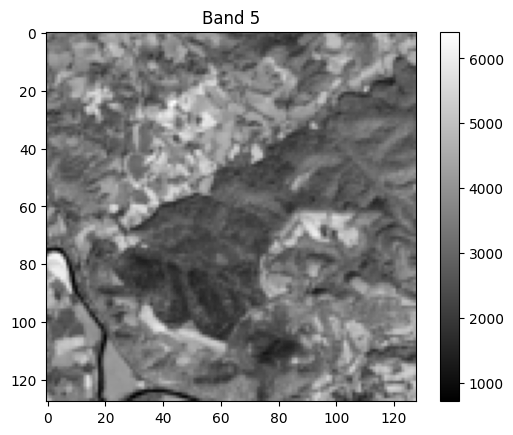

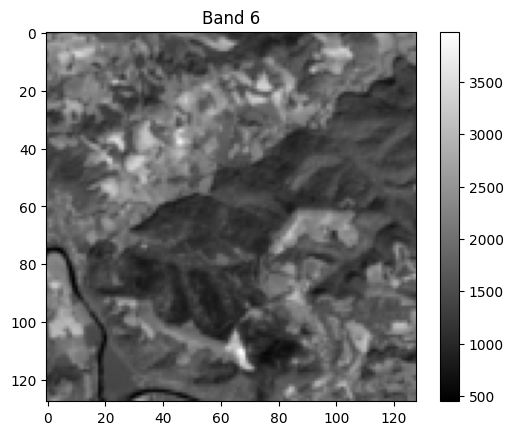

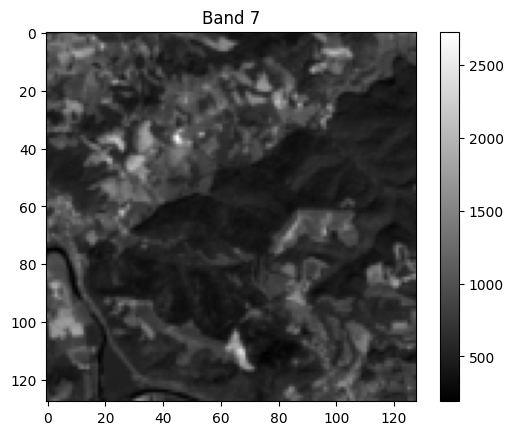

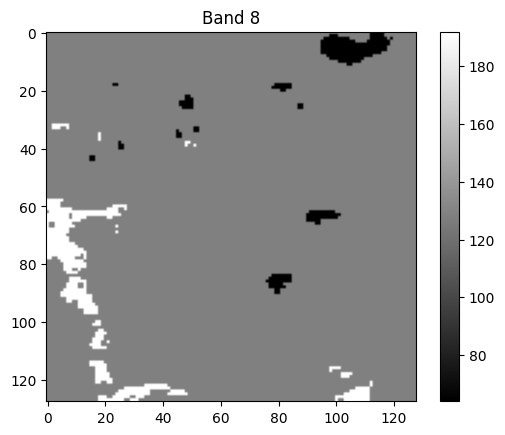

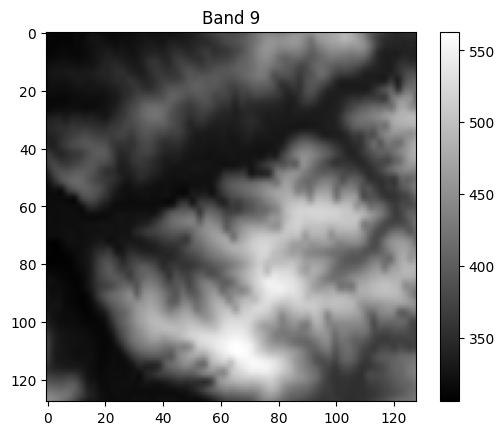

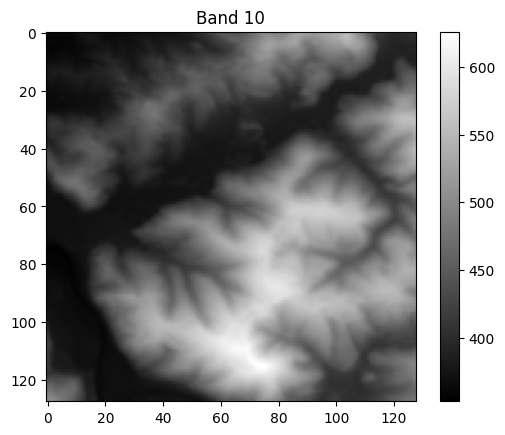

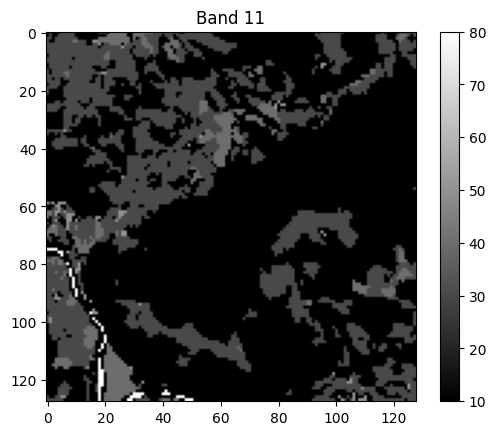

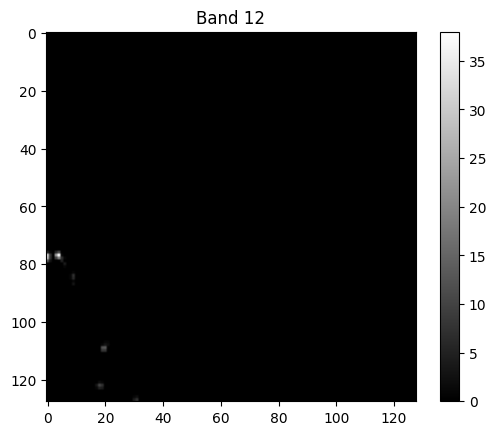

Width: 128, Height: 128, Bands: 1


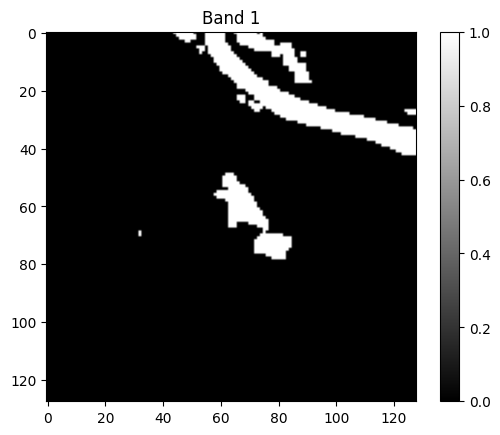

In [ ]:
# Function to load and visualize the bands
def load_and_visualize_img(file_path):
    with rasterio.open(file_path) as src:
        # Read the dataset's metadata
        profile = src.profile
        print(f"Width: {profile['width']}, Height: {profile['height']}, Bands: {profile['count']}")

        # Read all bands
        data = src.read()

        # Visualize each band
        for i in range(data.shape[0]):
            plt.figure()
            plt.imshow(data[i, :, :], cmap='gray')
            plt.title(f'Band {i+1}')
            plt.colorbar()
            plt.show()

        return data

# Load all images
image_data = [os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith('.tif')]
label_data = [os.path.join(labels_path, f) for f in os.listdir(labels_path) if f.endswith('.png')]

print(f"Number of images: {len(image_data)}")
print(f"Number of labels: {len(label_data)}")

# Example: Load and visualize the first image and label
img_1 = load_and_visualize_img(image_data[0])
lab_1 = load_and_visualize_img(label_data[0])


In [ ]:
def load_and_normalize_band(file_path):
    with rasterio.open(file_path) as src:
        data = src.read()
        norm_data = np.zeros_like(data, dtype=np.float32)

        # Normalize each band using normalization formula
        for i in range(data.shape[0]):
            band = data[i, :, :]
            norm_data[i, :, :] = (band - np.min(band)) / (np.max(band) - np.min(band))
    return norm_data

In [ ]:
# Initialize lists to store normalized images and labels
norm_image_list = []
norm_label_list = []

for img_data, lab_data in zip(image_data, label_data):
    norm_image_list.append(load_and_normalize_band(img_data))
    norm_label_list.append(load_and_normalize_band(lab_data))

# Convert lists to numpy arrays
norm_image_data = np.stack(norm_image_list, axis=0)
norm_label_data = np.stack(norm_label_list, axis=0)

print(f"Image data shape: {norm_image_data.shape}")
print(f"Label data shape: {norm_label_data.shape}")

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
<ipython-input-6-0263d2d9149c>:9: RuntimeWarning: invalid value encountered in divide
  norm_data[i, :, :] = (band - np.min(band)) / (np.max(band) - np.min(band))


Image data shape: (306, 12, 128, 128)
Label data shape: (306, 1, 128, 128)


In [ ]:
# Define the U-Net model
def unet_model(input_shape, num_classes=1, dropout_rate=0.3):
    def conv_block(input_tensor, num_filters, dropout_rate=0.3):
        x = layers.Conv2D(num_filters, (3, 3), padding='same', kernel_initializer='he_normal')(input_tensor)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(num_filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        if dropout_rate:
            x = layers.Dropout(dropout_rate)(x)

        return x

    def encoder_block(input_tensor, num_filters, dropout_rate):
        x = conv_block(input_tensor, num_filters, dropout_rate)
        p = layers.MaxPooling2D((2, 2))(x)
        return x, p

    def decoder_block(input_tensor, skip_tensor, num_filters):
        x = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
        x = layers.concatenate([x, skip_tensor])
        x = conv_block(x, num_filters)
        return x

    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1, p1 = encoder_block(inputs, 64, dropout_rate)
    c2, p2 = encoder_block(p1, 128, dropout_rate)

    # Bottleneck
    c3 = conv_block(p2, 256, dropout_rate)

    # Decoder
    u1 = decoder_block(c3, c2, 128)
    u2 = decoder_block(u1, c1, 64)

    if num_classes == 1:
        outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(u2)
    else:
        outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(u2)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
# Define the model
input_shape = (128, 128, 12)  # Assuming 12 bands
model = unet_model(input_shape)

class_weights = {0: 1, 1: 5}  # Adjust weights based on imbalance
model.compile(optimizer=Adam(learning_rate=1e-4), loss='dice_loss', metrics=['accuracy'], loss_weights=class_weights)

# Display the model's architecture
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 128, 128, 12)   │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_66 (Conv2D)        │ (None, 128, 128, 64)   │          6,976 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_40    │ (None, 128, 128, 64)   │            256 │ conv2d_66[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_40             │ (None, 128, 128, 64)   │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_67 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ activation_40[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_41    │ (None, 128, 128, 64)   │            256 │ conv2d_67[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_41             │ (None, 128, 128, 64)   │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 128, 128, 64)   │              0 │ activation_41[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 64, 64, 64)     │              0 │ dropout_20[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_68 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_42    │ (None, 64, 64, 128)    │            512 │ conv2d_68[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_42             │ (None, 64, 64, 128)    │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_69 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ activation_42[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_43    │ (None, 64, 64, 128)    │            512 │ conv2d_69[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_43             │ (None, 64, 64, 128)    │              0 │ batch_normalization_4… │
│ (Activation)         

 Total params: 1,873,153 (7.15 MB)

 Trainable params: 1,870,593 (7.14 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
X_train = np.transpose(norm_image_data, (0, 2, 3, 1))
Y_train = np.transpose(norm_label_data, (0, 2, 3, 1))

datagen.fit(X_train)
X_train.shape, Y_train.shape

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1495: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (306, 128, 128, 12) (12 channels).
  warnings.warn(


((306, 128, 128, 12), (306, 128, 128, 1))

In [ ]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred), axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3])
    dice_score = (2. * intersection + smooth) / (union + smooth)
    return 1. - tf.reduce_mean(dice_score)

model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy'])

In [ ]:
# Callbacks with updated model file extension
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(X_train, Y_train,
                    epochs=50,
                    batch_size=16,
                    validation_split=0.2,
                    callbacks=[early_stopping, checkpoint, lr_scheduler])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 309s 17s/step - accuracy: 0.6083 - loss: nan - val_accuracy: 0.6084 - val_loss: nan - learning_rate: 0.0010
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 317s 17s/step - accuracy: 0.6043 - loss: nan - val_accuracy: 0.6084 - val_loss: nan - learning_rate: 0.0010
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 279s 17s/step - accuracy: 0.6046 - loss: nan - val_accuracy: 0.6084 - val_loss: nan - learning_rate: 0.0010
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 320s 17s/step - accuracy: 0.5965 - loss: nan - val_accuracy: 0.6084 - val_loss: nan - learning_rate: 5.0000e-04
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 318s 17s/step - accuracy: 0.5839 - loss: nan - val_accuracy: 0.6084 - val_loss: nan - learning_rate: 5.0000e-04


In [ ]:
# Function to calculate metrics
def calculate_metrics(y_true, y_pred, threshold=0.5):
    # Apply threshold
    y_pred_thresh = (y_pred > threshold).astype(np.uint8)

    # Flatten arrays for metrics
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred_thresh.flatten()

    # Calculate metrics
    iou = jaccard_score(y_true_flat, y_pred_flat)
    precision = precision_score(y_true_flat, y_pred_flat)
    recall = recall_score(y_true_flat, y_pred_flat)
    f1 = f1_score(y_true_flat, y_pred_flat)

    return iou, precision, recall, f1

In [ ]:
# Make predictions in batches (to avoid memory issues)
batch_size = 16
num_samples = X_train.shape[0]
preds = np.zeros(Y_train.shape)

for i in range(0, num_samples, batch_size):
    batch_preds = model.predict(X_train[i:i + batch_size])
    preds[i:i + batch_size] = (batch_preds > 0.5).astype(np.uint8)

# Evaluate predictions
iou, precision, recall, f1 = calculate_metrics(Y_train, preds)

# Display the metrics
print(f"IoU: {iou:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


IoU: 0.0000, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


In [ ]:
def measure_NaN():
  # Check for NaN values in Y_train
  nan_count = np.isnan(Y_train).sum()
  return nan_count

print(f'values of NaN in Y_train before replace: {measure_NaN()}')

# Replace NaN values with 0 in Y_train
Y_train = np.nan_to_num(Y_train, nan=0)

print(f'values of NaN in Y_train after replace: {measure_NaN()}')

values of NaN in Y_train before replace: 786432
values of NaN in Y_train after replace: 0


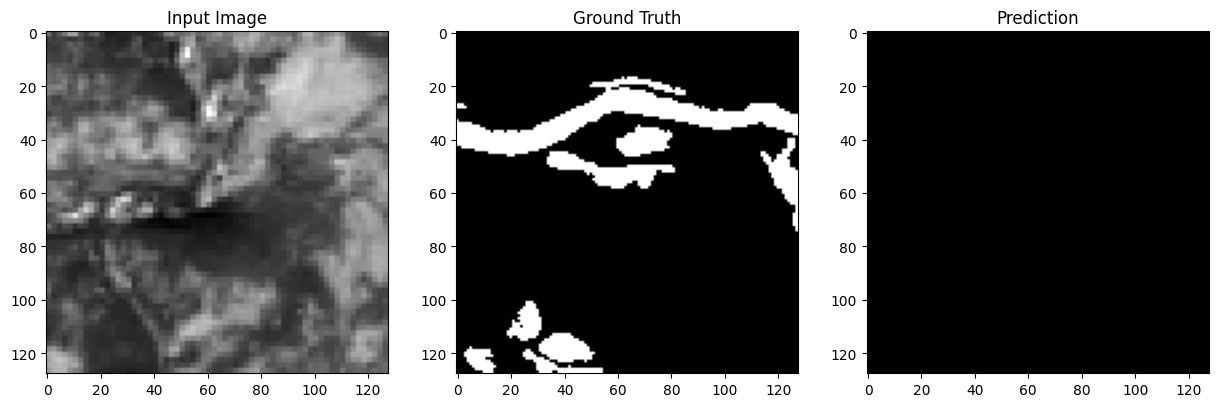

In [ ]:
idx = 10
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(X_train[idx, :, :, 0], cmap='gray')  # Show first channel of the image
plt.title("Input Image")

plt.subplot(1, 3, 2)
plt.imshow(Y_train[idx, :, :, 0], cmap='gray')  # Show ground truth
plt.title("Ground Truth")

plt.subplot(1, 3, 3)
plt.imshow(preds[idx, :, :, 0], cmap='gray')  # Show prediction
plt.title("Prediction")

plt.show()